## Setup

In [3]:
# imports
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os
import time

from kpca.utils import *
from kpca.kernel_pca import KernelPCA
from kpca.data import Loader, half_moons

# ipython
%matplotlib inline 
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

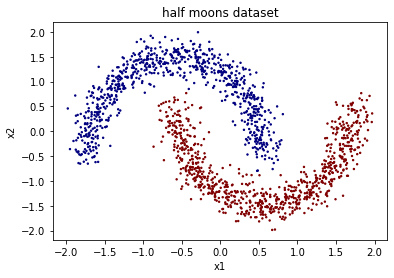

In [4]:
x,labels = half_moons()
plt.scatter(x[:,0],x[:,1],s=2,c=labels,cmap='jet')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('half moons dataset')
plt.show()

## Load Networks

In [5]:
net = KernelPCA(m=2, n=16, kernel='rbf', sig=0.4, lam=1e-3)
net.load_state_dict(torch.load('./trained-nets/halfmoons.pt'))

<All keys matched successfully>

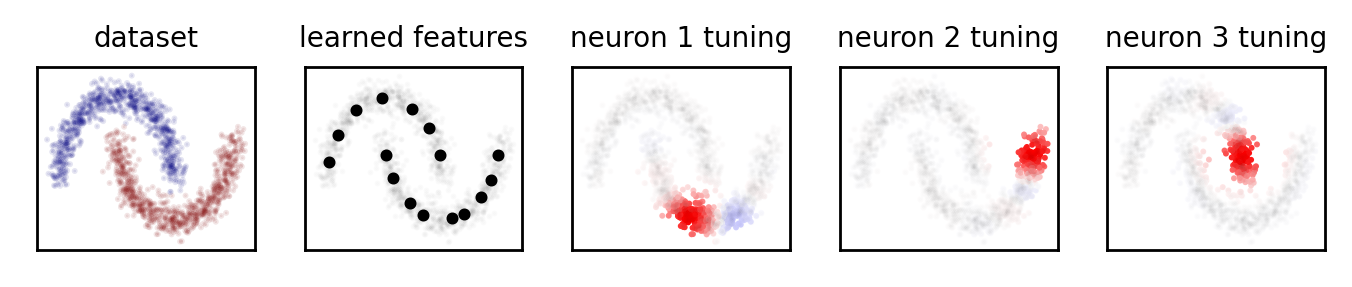

In [6]:
y = net(x)

fontsize=8
plt.figure(figsize=(5.5,1.25),dpi=250)
plt.subplot(151)
plt.scatter(x[:,0],x[:,1],s=0.5,c=labels,cmap='jet',alpha=0.1)

plt.xticks([])
plt.yticks([])
plt.title('dataset', fontsize=fontsize)

plt.subplot(152)
plt.scatter(net.w.detach()[:,0],net.w.detach()[:,1],color='black', s=6, alpha=1.0)
plt.scatter(x.detach()[:,0],x.detach()[:,1],color='black', s=0.5, alpha=0.02)

plt.xticks([])
plt.yticks([])
plt.title('learned features', fontsize=fontsize)

plt.subplot(153)
ix = 0
plt.scatter(x[:,0],x[:,1],s=0.5,c=y[:,ix]/y[:,ix].max(),cmap='bwr',vmin=-1,vmax=1)
plt.scatter(x[:,0],x[:,1],s=0.5,color='black',alpha=0.01)

plt.xticks([])
plt.yticks([])
plt.title('neuron 1 tuning', fontsize=fontsize)

plt.subplot(154)
ix = 1
plt.scatter(x[:,0],x[:,1],s=0.5,c=y[:,ix]/y[:,ix].max(),cmap='bwr',vmin=-1,vmax=1)
plt.scatter(x[:,0],x[:,1],s=0.5,color='black',alpha=0.01)

plt.xticks([])

plt.xticks([])
plt.yticks([])
plt.title('neuron 2 tuning', fontsize=fontsize)

plt.subplot(155)
ix = 2
plt.scatter(x[:,0],x[:,1],s=0.5,c=y[:,ix]/y[:,ix].max(),cmap='bwr',vmin=-1,vmax=1)
plt.scatter(x[:,0],x[:,1],s=0.5,color='black',alpha=0.01)

plt.xticks([])

plt.xticks([])
plt.yticks([])
plt.title('neuron 3 tuning', fontsize=fontsize)

plt.tight_layout()
plt.savefig('figures/halfmoons/half-moons-overview.pdf')
plt.show()

/tmp/ipykernel_866092/896448583.py:5: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  l,v = fxx.symeig(eigenvectors=True)


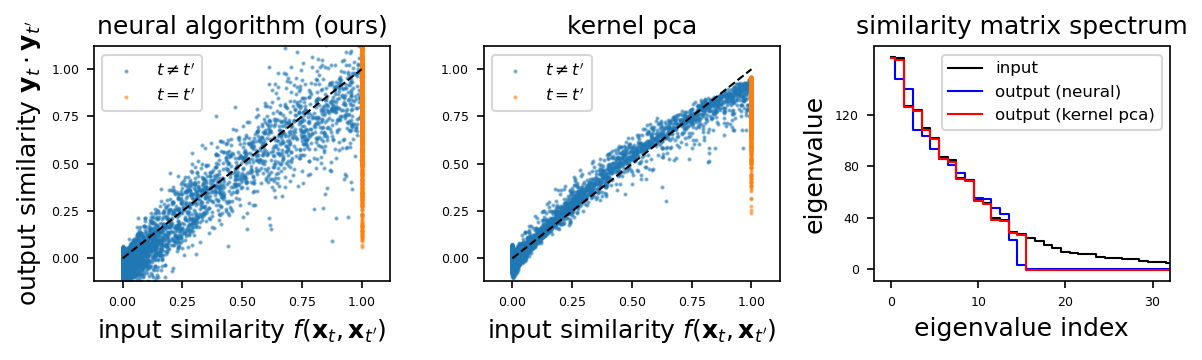

In [7]:
y = net(x)
yy = y @ y.t()
fxx = net.f(x,x)

l,v = fxx.symeig(eigenvectors=True)
z = v[:,-y.shape[1]:] @ l[-y.shape[1]:].sqrt().diag() @ v[:,-y.shape[1]:].t()
zz = z @ z.t()

plt.figure(figsize=(8,2.5),dpi=150)

###########
# alpha = 1
###########
plt.subplot(131)
t = 10000
ixs = torch.randperm(len(offdiag(fxx)))[:t]
plt.scatter(offdiag(fxx).detach().cpu().numpy()[ixs], offdiag(yy).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(fxx).detach().cpu().numpy(), ondiag(yy).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks(torch.linspace(0,1,5),fontsize=6)
plt.xlim(-0.12,1.12)
plt.yticks(torch.linspace(0,1,5),fontsize=6)
plt.ylim(-0.12,1.12)
plt.legend(fontsize=8)

plt.legend(fontsize=8)
plt.xlabel(r"input similarity $f(\mathbf{x}_t,\mathbf{x}_{t'})$",fontsize=12)
plt.ylabel(r"output similarity $\mathbf{y}_t \cdot \mathbf{y}_{t'}$",fontsize=12)
plt.title("neural algorithm (ours)",fontsize=12)

plt.subplot(132)
ixs = torch.randperm(len(offdiag(fxx)))[:t]
plt.scatter(offdiag(fxx).detach().cpu().numpy()[ixs], offdiag(zz).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(fxx).detach().cpu().numpy(), ondiag(zz).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks(torch.linspace(0,1,5),fontsize=6)
plt.xlim(-0.12,1.12)
plt.yticks(torch.linspace(0,1,5),fontsize=6)
plt.ylim(-0.12,1.12)
plt.legend(fontsize=8)

plt.xlabel(r"input similarity $f(\mathbf{x}_t,\mathbf{x}_{t'})$",fontsize=12)
# plt.ylabel(r"output similarity $\mathbf{y}_t \cdot \mathbf{y}_{t'}$",fontsize=12)
plt.title("kernel pca",fontsize=12)

plt.subplot(133)
plt.plot(fxx.symeig()[0].flip(0), color='black', linewidth=1, drawstyle='steps-mid', label='input')
plt.plot(yy.symeig()[0].flip(0), color='blue', linewidth=1, drawstyle='steps-mid', label='output (neural)')
plt.plot(zz.symeig()[0].flip(0)-1, color='red', linewidth=1, drawstyle='steps-mid', label='output (kernel pca)')

plt.xticks(torch.linspace(0,30,4),fontsize=6)
plt.xlim(-2,32)
plt.yticks(torch.linspace(0,120,4),fontsize=6)
# plt.ylim(-2,122)
plt.legend(fontsize=8)

plt.xlabel(r"eigenvalue index",fontsize=12)
plt.ylabel(r"eigenvalue",fontsize=12)
plt.title("similarity matrix spectrum",fontsize=12)

plt.tight_layout()

plt.savefig('./figures/halfmoons/half-moons-matching.pdf')
plt.show()

In [17]:
from hcgame.classifiers import LogisticRegressionClassifier, NearestNeighborClassifier, accuracy_curve

def evaluate(u,u_,y,y_,seeds,ks):
    scores = {}
    for seed in seeds:
        for k in ks:
            # set seed
            torch.random.manual_seed(seed)

            # select data
            ut = torch.zeros(k*10,u.shape[1],dtype=u.dtype, device=u.device)
            yt = torch.zeros(k*10,dtype=y.dtype, device=y.device)
            for i in range(10):
                ixs = torch.where(y==i)[0]
                ixs = ixs[torch.randperm(len(ixs))[:k]]

                ut[i*k:(i+1)*k] = u[ixs].clone()
                yt[i*k:(i+1)*k] = y[ixs].clone()

            # train classifier
            clf = NearestNeighborClassifier('euclidean', 1)
            clf.train(ut,yt)
            s_trn,s_val = None, clf.score(u_,y_)

            # log result
            scores[seed,k] = (s_trn,s_val)
            print('seed: {}, k: {}, s_trn: {}, s_val: {}'.format(seed, k, s_trn, s_val))

    return scores

In [18]:
device = 'cpu'
seeds = [0]
ks = [1,3,10,30,100,300,1000,3000]

xscores_euc = evaluate(x.to(device), x_.to(device), labels.to(device), labels_.to(device),seeds,ks)
y1scores_euc = evaluate(net1(x).to(device), net1(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y2scores_euc = evaluate(net2(x).to(device), net2(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y3scores_euc = evaluate(net3(x).to(device), net3(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y4scores_euc = evaluate(net4(x).to(device), net4(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)

seed: 0, k: 1, s_trn: None, s_val: 0.41940000653266907
seed: 0, k: 3, s_trn: None, s_val: 0.5763000249862671
seed: 0, k: 10, s_trn: None, s_val: 0.7197999954223633
seed: 0, k: 30, s_trn: None, s_val: 0.82669997215271
seed: 0, k: 100, s_trn: None, s_val: 0.8862000107765198
seed: 0, k: 300, s_trn: None, s_val: 0.9291999936103821
seed: 0, k: 1000, s_trn: None, s_val: 0.9526000022888184
seed: 0, k: 3000, s_trn: None, s_val: 0.9659000039100647
seed: 0, k: 1, s_trn: None, s_val: 0.4228000044822693
seed: 0, k: 3, s_trn: None, s_val: 0.5806999802589417
seed: 0, k: 10, s_trn: None, s_val: 0.7271999716758728
seed: 0, k: 30, s_trn: None, s_val: 0.8331000208854675
seed: 0, k: 100, s_trn: None, s_val: 0.8888000249862671
seed: 0, k: 300, s_trn: None, s_val: 0.9322999715805054
seed: 0, k: 1000, s_trn: None, s_val: 0.954800009727478
seed: 0, k: 3000, s_trn: None, s_val: 0.9670000076293945
seed: 0, k: 1, s_trn: None, s_val: 0.3612000048160553
seed: 0, k: 3, s_trn: None, s_val: 0.5430999994277954
seed: 

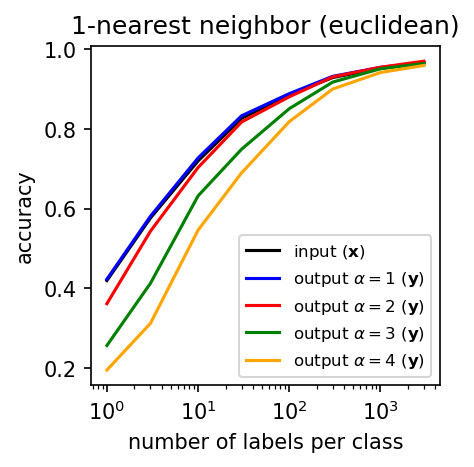

In [19]:
plt.figure(figsize=(3, 3), dpi=150)

plt.plot(ks, [sum([xscores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output $\alpha=1$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y2scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output $\alpha=2$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y3scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output $\alpha=3$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y4scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output $\alpha=4$ ($\mathbf{y}$)')

plt.legend(fontsize=8)
plt.xscale('log')

plt.xlabel('number of labels per class')
plt.ylabel('accuracy')
plt.title('1-nearest neighbor (euclidean)')
plt.show()

#### Cosine

In [20]:
from hcgame.classifiers import LogisticRegressionClassifier, NearestNeighborClassifier, accuracy_curve

def evaluate(u,u_,y,y_,seeds,ks):
    scores = {}
    for seed in seeds:
        for k in ks:
            # set seed
            torch.random.manual_seed(seed)

            # select data
            ut = torch.zeros(k*10,u.shape[1],dtype=u.dtype, device=u.device)
            yt = torch.zeros(k*10,dtype=y.dtype, device=y.device)
            for i in range(10):
                ixs = torch.where(y==i)[0]
                ixs = ixs[torch.randperm(len(ixs))[:k]]

                ut[i*k:(i+1)*k] = u[ixs].clone()
                yt[i*k:(i+1)*k] = y[ixs].clone()

            # train classifier
            clf = NearestNeighborClassifier('cosine', 1)
            clf.train(ut,yt)
            s_trn,s_val = None, clf.score(u_,y_)

            # log result
            scores[seed,k] = (s_trn,s_val)
            print('seed: {}, k: {}, s_trn: {}, s_val: {}'.format(seed, k, s_trn, s_val))

    return scores

In [21]:
device = 'cpu'
seeds = [0]
ks = [1,3,10,30,100,300,1000,3000]

xscores_cos = evaluate(x.to(device), x_.to(device), labels.to(device), labels_.to(device),seeds,ks)
y1scores_cos = evaluate(net1(x).to(device), net1(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y2scores_cos = evaluate(net2(x).to(device), net2(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y3scores_cos = evaluate(net3(x).to(device), net3(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y4scores_cos = evaluate(net4(x).to(device), net4(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)

seed: 0, k: 1, s_trn: None, s_val: 0.43709999322891235
seed: 0, k: 3, s_trn: None, s_val: 0.597000002861023
seed: 0, k: 10, s_trn: None, s_val: 0.7484999895095825
seed: 0, k: 30, s_trn: None, s_val: 0.8528000116348267
seed: 0, k: 100, s_trn: None, s_val: 0.9053999781608582
seed: 0, k: 300, s_trn: None, s_val: 0.9381999969482422
seed: 0, k: 1000, s_trn: None, s_val: 0.9588000178337097
seed: 0, k: 3000, s_trn: None, s_val: 0.9714999794960022
seed: 0, k: 1, s_trn: None, s_val: 0.4399000108242035
seed: 0, k: 3, s_trn: None, s_val: 0.602400004863739
seed: 0, k: 10, s_trn: None, s_val: 0.7530999779701233
seed: 0, k: 30, s_trn: None, s_val: 0.8561000227928162
seed: 0, k: 100, s_trn: None, s_val: 0.9078999757766724
seed: 0, k: 300, s_trn: None, s_val: 0.9401000142097473
seed: 0, k: 1000, s_trn: None, s_val: 0.9595000147819519
seed: 0, k: 3000, s_trn: None, s_val: 0.9735000133514404
seed: 0, k: 1, s_trn: None, s_val: 0.4408000111579895
seed: 0, k: 3, s_trn: None, s_val: 0.6036999821662903
seed:

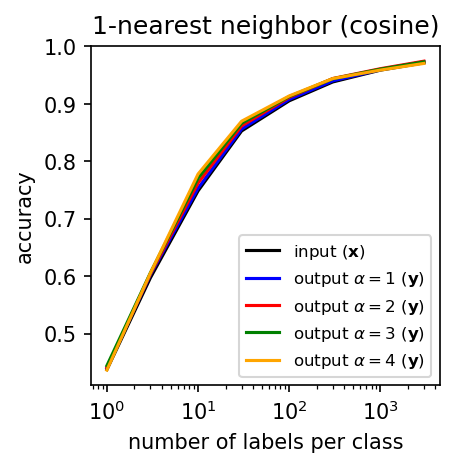

In [22]:
plt.figure(figsize=(3, 3), dpi=150)

plt.plot(ks, [sum([xscores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output $\alpha=1$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y2scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output $\alpha=2$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y3scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output $\alpha=3$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y4scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output $\alpha=4$ ($\mathbf{y}$)')

plt.legend(fontsize=8)
plt.xscale('log')

plt.xlabel('number of labels per class')
plt.ylabel('accuracy')
plt.title('1-nearest neighbor (cosine)')
plt.show()

#### Linear

In [23]:
from hcgame.classifiers import LogisticRegressionClassifier, accuracy_curve

def evaluate(u,u_,y,y_,seeds,ks,lams):
    scores = {}
    for seed in seeds:
        for k in ks:
            for lam in lams:
                # set seed
                torch.random.manual_seed(seed)

                # select data
                ut = torch.zeros(k*10,u.shape[1],dtype=u.dtype, device=u.device)
                yt = torch.zeros(k*10,dtype=y.dtype, device=y.device)
                for i in range(10):
                    ixs = torch.where(y==i)[0]
                    ixs = ixs[torch.randperm(len(ixs))[:k]]

                    ut[i*k:(i+1)*k] = u[ixs].clone()
                    yt[i*k:(i+1)*k] = y[ixs].clone()

                # train classifier
                clf = LogisticRegressionClassifier(u.shape[1],10,lam).to(u.device)
                clf.train(ut,yt)
                s_trn,s_val = clf.score(ut,yt), clf.score(u_,y_)

                # log result
                improved = s_val > scores.get((seed,k),(0,0,None))[1]
                if improved:
                    scores[seed,k] = (s_trn,s_val,lam)
                print('seed: {}, k: {}, lam: {}, s_trn: {}, s_val: {}, improved: {}'.format(seed, k, lam, s_trn, s_val, improved))

    return scores

In [24]:
device = 'cpu'
seeds = [0]
ks = [1,3,10,30,100,300,1000,3000]
lams = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]

# def normalize(x):
#     return (x-x.mean(0)) / x.std()

# xh = normalize(net.x)
# yh = normalize(net.y)

xscores_lin = evaluate(x.to(device), x_.to(device), labels.to(device), labels_.to(device),seeds,ks,lams)
y1scores_lin = evaluate(net1(x).to(device), net1(x_).to(device), labels.to(device), labels_.to(device),seeds,ks,lams)
y2scores_lin = evaluate(net2(x).to(device), net2(x_).to(device), labels.to(device), labels_.to(device),seeds,ks,lams)
y3scores_lin = evaluate(net3(x).to(device), net3(x_).to(device), labels.to(device), labels_.to(device),seeds,ks,lams)
y4scores_lin = evaluate(net4(x).to(device), net4(x_).to(device), labels.to(device), labels_.to(device),seeds,ks,lams)


seed: 0, k: 1, lam: 1e-05, s_trn: 1.0, s_val: 0.4603999853134155, improved: True
seed: 0, k: 1, lam: 0.0001, s_trn: 1.0, s_val: 0.4602999985218048, improved: False
seed: 0, k: 1, lam: 0.001, s_trn: 1.0, s_val: 0.45910000801086426, improved: False
seed: 0, k: 1, lam: 0.01, s_trn: 1.0, s_val: 0.4577000141143799, improved: False
seed: 0, k: 1, lam: 0.1, s_trn: 1.0, s_val: 0.4562000036239624, improved: False
seed: 0, k: 1, lam: 1.0, s_trn: 1.0, s_val: 0.453000009059906, improved: False
seed: 0, k: 1, lam: 10.0, s_trn: 1.0, s_val: 0.4401000142097473, improved: False
seed: 0, k: 3, lam: 1e-05, s_trn: 1.0, s_val: 0.6298999786376953, improved: True
seed: 0, k: 3, lam: 0.0001, s_trn: 1.0, s_val: 0.6301000118255615, improved: True
seed: 0, k: 3, lam: 0.001, s_trn: 1.0, s_val: 0.6305000185966492, improved: True
seed: 0, k: 3, lam: 0.01, s_trn: 1.0, s_val: 0.631600022315979, improved: True
seed: 0, k: 3, lam: 0.1, s_trn: 1.0, s_val: 0.6315000057220459, improved: False
seed: 0, k: 3, lam: 1.0, s_tr

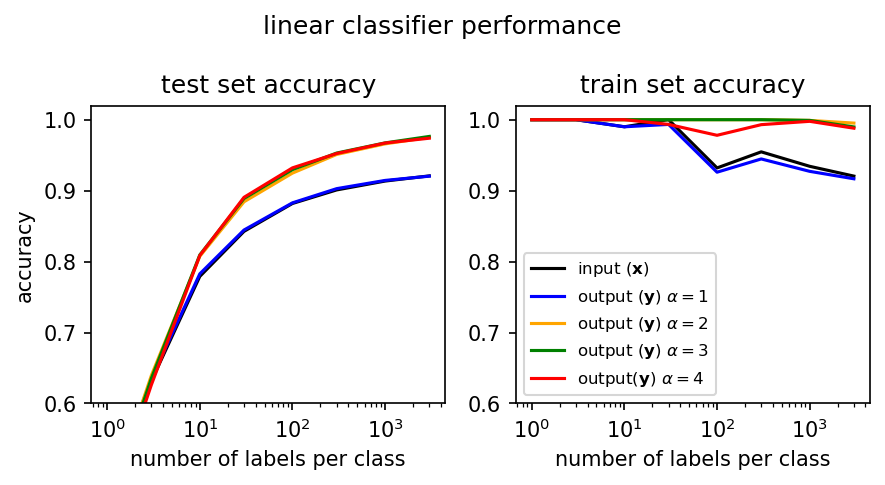

In [25]:
plt.figure(figsize=(6, 3.25), dpi=150)
plt.subplot(121)
plt.plot(ks, [sum([xscores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output ($\mathbf{y}$) $\alpha=1$')
plt.plot(ks, [sum([y2scores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output ($\mathbf{y}$) $\alpha=2$')
plt.plot(ks, [sum([y3scores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output ($\mathbf{y}$) $\alpha=3$')
plt.plot(ks, [sum([y4scores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output ($\mathbf{y}$) $\alpha=4$')

plt.xscale('log')

plt.xlabel('number of labels per class')
plt.ylabel('accuracy')
plt.title('test set accuracy')

plt.ylim(0.6,1.02)

plt.subplot(122)
plt.plot(ks, [sum([xscores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output ($\mathbf{y}$) $\alpha=1$')
plt.plot(ks, [sum([y2scores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output ($\mathbf{y}$) $\alpha=2$')
plt.plot(ks, [sum([y3scores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output ($\mathbf{y}$) $\alpha=3$')
plt.plot(ks, [sum([y4scores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output($\mathbf{y}$) $\alpha=4$')

plt.xscale('log')
plt.xlabel('number of labels per class')
plt.title('train set accuracy')
plt.legend(fontsize=8)

plt.ylim(0.6,1.02)

plt.suptitle('linear classifier performance')
plt.tight_layout()

plt.savefig('./kernel-smatching-figures-uncentered/linear-classifier.pdf')
plt.show()

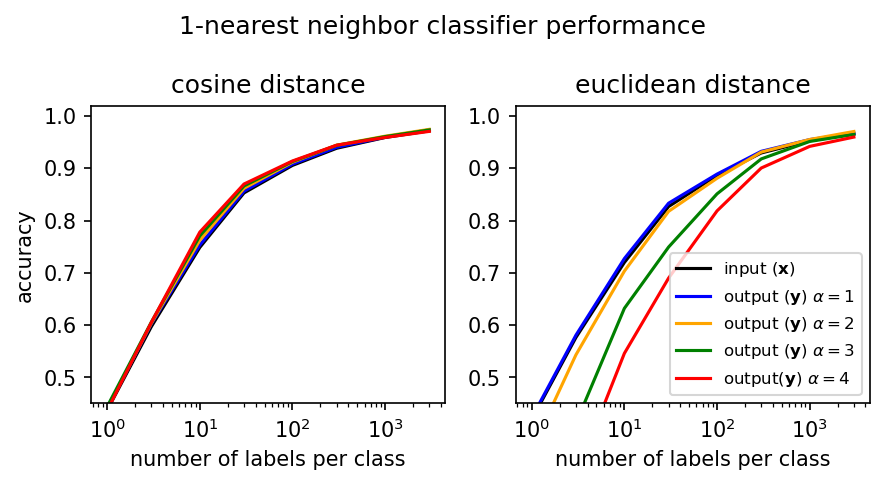

In [26]:
plt.figure(figsize=(6, 3.25), dpi=150)
plt.subplot(121)
plt.plot(ks, [sum([xscores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output ($\mathbf{y}$) $\alpha=1$')
plt.plot(ks, [sum([y2scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output ($\mathbf{y}$) $\alpha=2$')
plt.plot(ks, [sum([y3scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output ($\mathbf{y}$) $\alpha=3$')
plt.plot(ks, [sum([y4scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output ($\mathbf{y}$) $\alpha=4$')

plt.xscale('log')

plt.xlabel('number of labels per class')
plt.ylabel('accuracy')
plt.title('cosine distance')

plt.ylim(0.45,1.02)

plt.subplot(122)
plt.plot(ks, [sum([xscores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output ($\mathbf{y}$) $\alpha=1$')
plt.plot(ks, [sum([y2scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output ($\mathbf{y}$) $\alpha=2$')
plt.plot(ks, [sum([y3scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output ($\mathbf{y}$) $\alpha=3$')
plt.plot(ks, [sum([y4scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output($\mathbf{y}$) $\alpha=4$')

plt.xscale('log')
plt.xlabel('number of labels per class')
plt.title('euclidean distance')
plt.legend(fontsize=8)

plt.ylim(0.45,1.02)

plt.suptitle('1-nearest neighbor classifier performance')
plt.tight_layout()

plt.savefig('./kernel-smatching-figures-uncentered/nearest-neighbor.pdf')
plt.show()